# Introduction and Imports

This notebook provides a step-by-step tutorial for calibrating data. This tutorial simulates the data to be calibrated on-the-fly and requires a few extra packages for simulation and covariance model building. Visibility simulation is performed using the `matvis` wrapper provided in `hera_sim`. This requires `pyradiosky`, `pyuvdata`, and `pyuvsim`, as well as these packages' dependencies. Visibility and beam data is managed with tools provided by `pyuvdata`. For simplicity, this tutorial uses an analytic beam model. <b>If you find that there are any topics in this notebook that should be more clearly covered, please raise an issue with your concerns.</b>

In [1]:
# Packages required for calibration
import corrcal  # For performing the likelihood and gradient operations
import numpy as np
from scipy.optimize import minimize  # For running calibration

# Packages to help with covariance model building and simulation
import hera_sim
from astropy import constants, units
from astropy.coordinates import Latitude, Longitude, AltAz
from astropy.coordinates import EarthLocation, SkyCoord
from astropy_healpix import HEALPix  # For interpolating to the image plane
from astropy.time import Time
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from pyradiosky import SkyModel
from pyuvdata import AiryBeam

# Other packages
import healpy  # For various operations on the sphere
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d  # For visualization purposes
%matplotlib inline

/home/rpascua/miniconda3/envs/test_corrcal/lib/python3.13/site-packages/pyuvdata/analytic_beam.py:174: UserWarning: basis_vector_type was not defined, defaulting to azimuth and zenith_angle.
  warnings.warn(
/home/rpascua/miniconda3/envs/test_corrcal/lib/python3.13/site-packages/matvis/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Setup 

The setup section of this tutorial contains two parts: preparing data products for simulation, and preparing data products for covariance model building. Some of the objects are reused between the two steps, and the example shown here may not be appropriate for every use case, as different experiments may use different data structures and simulation tools.

### Point Source Model

For this example, information about the point sources is stored in a `npz` archive. The sources are characterized by their right ascension and declination, as well as their flux density. The source catalog has source counts consistent with the low-frequency radio sky, but does not feature any sort of clustering. Since this is a single-channel example, there is no need for spectral evolution information. Rather than cover the full sky, the provided example source catalog only covers a $30^\circ \times 30^\circ$ patch of the sky, centered at zenith for the chosen observation time and observatory location.

In [2]:
source_catalog = corrcal.DATA_PATH / "example_source_catalog.npz"
catalog_info = dict(np.load(source_catalog))
fluxes = catalog_info["fluxes"] * getattr(units, str(catalog_info["flux_unit"]))
ra = catalog_info["ra"] * getattr(units, str(catalog_info["ra_unit"]))
dec = catalog_info["dec"] * getattr(units, str(catalog_info["dec_unit"]))

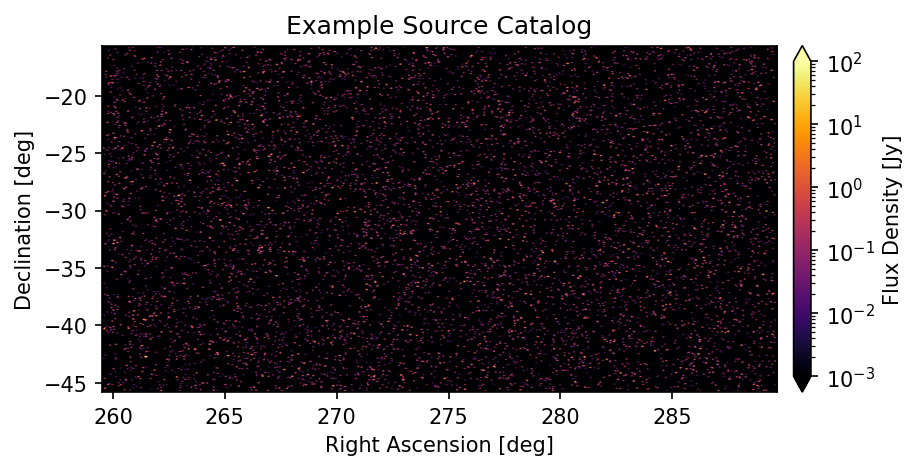

In [3]:
# Bin up the sources and plot the result to visualize the source catalog
buffer = 0.1 * units.deg
n_bins = 1025
ra_bounds = (
    (ra.min() - buffer).to(units.rad).value,
    (ra.max() + buffer).to(units.rad).value,
)
dec_bounds = (
    (dec.min() - buffer).to(units.rad).value,
    (dec.max() + buffer).to(units.rad).value,
)
ra_bins = np.linspace(*ra_bounds, n_bins+1)
dec_bins = np.linspace(*dec_bounds, n_bins+1)
binned_flux = binned_statistic_2d(
    ra.to(units.rad).value,
    dec.to(units.rad).value,
    fluxes.to(units.Jy).value,
    statistic="sum",
    bins=(ra_bins, dec_bins),
)[0]

# Smooth the binned flux to help with visualization.
kernel_width = 1 * units.arcmin.to(units.rad)
plot_ra = 0.5 * (ra_bins[1:]+ra_bins[:-1])
plot_ra -= plot_ra.mean()
plot_dec = 0.5 * (dec_bins[1:]+dec_bins[:-1])
plot_dec -= plot_dec.mean()
kernel = np.exp(
    -0.5 * plot_dec[:,None]**2 / kernel_width**2
) * np.exp(-0.5 * plot_ra[None,:]**2 / kernel_width**2)
smoothed_flux = np.abs(
    fftshift(ifft2(fft2(kernel) * fft2(binned_flux)))
)

# Now set up the plotting elements.
norm = plt.cm.colors.LogNorm(vmin=1e-3, vmax=1e2)
cmap = plt.cm.inferno.copy()
cmap.set_bad('k')
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
extent = np.array(ra_bounds + dec_bounds) * units.rad.to(units.deg)

# Finally, actually make the plot.
fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=150)
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")
ax.set_title("Example Source Catalog")
ax.imshow(smoothed_flux, origin="lower", aspect="auto", norm=norm, cmap=cmap, extent=extent)
fig.colorbar(smap, ax=ax, label="Flux Density [Jy]", extend="both", pad=0.02);

**Figure 1 |** Point source catalog used for this tutorial.

At this point, we have information about all of the point sources that will be used in simulation, and we will use a very small subset of these sources for calibration. For clarity, the relevant information is stored as follows:  
  
* Source fluxes are contained as `astropy` quantities in a `numpy` array in the object `fluxes`.
* Source positions are tracked through their right ascension and declination; both are contained as `astropy` quantities in `numpy` arrays.
    * The right ascensions are stored in the `ra` object.
    * The declinations are stored in the `dec` object.

### Diffuse Sky Setup

For this example, we will use a realization of a Gaussian random field with a $(1+\ell)^{-2}$ angular power spectrum (plus a monopole) as the diffuse sky component. The sky intensity will be scaled so that the power in the diffuse emission is somewhat comparable to the power in the point source emission.

In [4]:
# Generate the diffuse sky emission.
max_Tsky = 100 * units.K  # Maximum brightness temperature of the generated field..
nside = 64  # HEALPix nside for the diffuse map.
ell_max = 3*nside - 1  # Higher multipoles than this aren't measured by the map.
ells = np.arange(ell_max+1, dtype=float)
sky_pspec = 1 / (1+ells)**2  # Just use a simple power spectrum C_\ell ~ 1/\ell^2.
Tsky = healpy.synfast(sky_pspec, nside) * units.K  # Generate a realization of this power spectrum.
monopole = np.abs(Tsky.min())
Tsky += monopole  # Make the diffuse signal nonnegative.
rescaling = max_Tsky / Tsky.max()
Tsky *= rescaling  # Rescale the map to the desired brightness.

/home/rpascua/miniconda3/envs/test_corrcal/lib/python3.13/site-packages/healpy/visufunc.py:223: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  f = pylab.figure(fig, figsize=(8.5, 5.4))


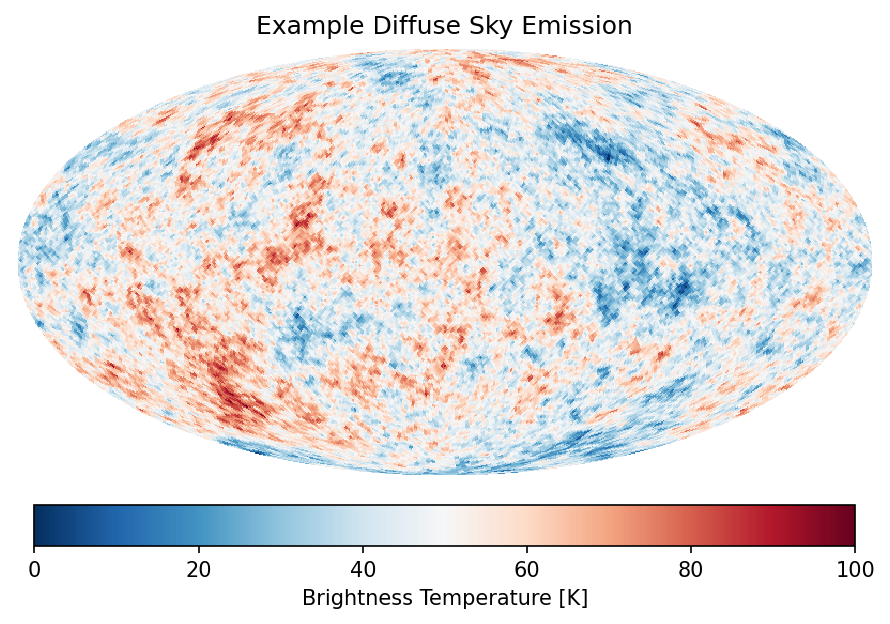

In [5]:
# Quickly visualize the diffuse component
plt.figure(figsize=(6,4), dpi=150)
healpy.mollview(
    Tsky.value,
    fig=1,
    title="",
    cmap="RdBu_r",
    cbar=False,
    norm=None,
    min=Tsky[Tsky>0].min().value,
    max=Tsky.max().value,
)

# Manually make the colorbar and title
norm = plt.cm.colors.Normalize(vmin=0, vmax=Tsky.max().value)
cmap = plt.cm.RdBu_r
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(
    smap,
    ax=plt.gca(),
    orientation="horizontal",
    label="Brightness Temperature [K]",
    shrink=0.95,
    pad=0.05,
)
plt.title("Example Diffuse Sky Emission");

**Figure 2 |** Diffuse component of the sky intensity used for this example. A monopole term has been added to ensure that the intensity is non-negative. Red regions are brighter than the average; blue regions are dimmer than the average.

### Simulation Setup

Now we'll finish setting things up for running visibility simulation. This requires setting up `SkyModel` and `UVData` objects, as well as defining the per-antenna beams. **Note that the observation time chosen here is chosen so that the point sources are uniformly distributed about zenith.**

In [6]:
# Required parameters for making a UVData object
obstime = 2459917.00243  # Julian date
integration_time = 10  # seconds
Ntimes = 1
freq = 150e6  # Hz
channel_width = 100e3  # Hz
Nfreqs = 1
polarizations = ["xx",]
array_layout = hera_sim.antpos.hex_array(3, outriggers=0, split_core=False)
latitude = -30.721527099609585  # Degrees
longitude = 21.42830467224121  # Degrees
altitude = 1073.0000000121072  # Meters

# Additional information.
diameter = 14

In [7]:
# Create the UVData object.
src_uvdata = hera_sim.io.empty_uvdata(
    Ntimes=Ntimes,
    start_time=obstime,
    integration_time=integration_time,
    Nfreqs=Nfreqs,
    start_freq=freq,
    channel_width=channel_width,
    array_layout=array_layout,
    polarizations=polarizations,
    telescope_location=[latitude, longitude, altitude],
)
# For sanity checks later.
diff_uvdata = src_uvdata.copy()

No beam information, so cannot determine telescope mount_type, feed_array or feed_angle. Specify a telescope config file in the obs param file to get beam information or, if calling from `initialize_uvdata_from_keywords`, specify mount_type, feed_array and feed_angle.
The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.


In [8]:
# Create the beam model.
beam = AiryBeam(diameter=diameter)
beam_ids = [0,] * src_uvdata.Nants_data

In [9]:
# Generate the SkyModel for the source catalog.
source_stokes = np.zeros((4, 1, fluxes.size), dtype=float) * units.Jy
source_stokes[0,0] = fluxes
source_model = SkyModel(
    name=np.arange(fluxes.size).astype(str),
    ra=Longitude(ra),
    dec=Latitude(dec),
    stokes=source_stokes,
    spectral_type="flat",  # No spectral evolution
    component_type="point",
    frame="icrs",
    freq_array=np.array([freq])*units.Hz,
)

In [10]:
# The diffuse matrix is in units of Jy, so we need to make the appropriate conversions.
wavelength = constants.c.si.value / diff_uvdata.freq_array[0]
K_to_Jy = 2 * constants.k_B.si.value / (1e-26 * wavelength**2)
obs_pspec = sky_pspec.copy()
obs_pspec[0] += monopole.to(units.K).value ** 2  # C_0 is the square of the sky average
obs_pspec *= (K_to_Jy * rescaling / 2) ** 2  # Convert to Jy, account for Stokes convention and scaling
npix = healpy.nside2npix(nside)

# Prepare the diffuse sky model.
stokes = np.zeros((4,Nfreqs,npix), dtype=float)
stokes[0] = Tsky
diff_model = SkyModel(
    stokes=stokes*units.K,
    spectral_type="full",
    component_type="healpix",
    nside=nside,
    frame="icrs",
    hpx_inds=np.arange(npix),
    freq_array=diff_uvdata.freq_array * units.Hz,
)

# Convert the diffuse component to Jy (i.e., approximate each pixel as a discrete source).
diff_model.kelvin_to_jansky()
diff_model.stokes *= healpy.nside2pixarea(nside) * units.sr
pix_dec, pix_ra = healpy.pix2ang(nside, np.arange(npix))
pix_dec = np.pi/2 - pix_dec  # Convert from co-latitude to declination.
diff_model = SkyModel(
    name=np.arange(npix).astype(str),
    stokes=diff_model.stokes,
    ra=Longitude(pix_ra*units.rad),
    dec=Latitude(pix_dec*units.rad),
    spectral_type="full",
    component_type="point",
    frame="icrs",
    freq_array=diff_uvdata.freq_array*units.Hz,
)

## Run Simulation

In [11]:
# Simulate the diffuse visibilities.
data_model = hera_sim.visibilities.ModelData(
    uvdata=diff_uvdata,
    sky_model=diff_model,
    beams=[beam,],
    beam_ids=beam_ids,
)
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.MatVis(),
)
simulation.simulate();

In [12]:
# Simulate the point source visibilities.
data_model = hera_sim.visibilities.ModelData(
    uvdata=src_uvdata,
    sky_model=source_model,
    beams=[beam,],
    beam_ids=beam_ids,
)
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.MatVis(),
)
simulation.simulate();

In [13]:
uvdata = src_uvdata.copy()
uvdata.data_array += diff_uvdata.data_array

## Prepare Model Covariance

For a more complete discussion on the model covariance and how its components are constructed, refer to Section 3 of Pascua, Sievers, & Liu 2026. This section briefly covers the relevant details.

The model covariance is decomposed in terms of smaller matrices via  
  
$$
    \mathbf{C} = \mathbf{N} + \mathbf{G} \boldsymbol{\Delta \Delta}^T \mathbf{G}^T + \mathbf{G} \boldsymbol{\Sigma \Sigma}^T \mathbf{G}^T,
$$
  
where $\mathbf{N}$ is a diagonal matrix tracking the noise variance, $\boldsymbol{\Delta}$ is the "diffuse" matrix, $\boldsymbol{\Sigma}$ is the "source" matrix, and $\mathbf{G}$ is the block-diagonal gain matrix. The diffuse matrix formally encodes the covariance in the data that arises from a Gaussian Random Field on the sky, but in practical terms the diffuse matrix encodes the array redundancy and known deviations from redundancy. The source matrix encodes the covariance generated by the presence of bright point sources on the sky. Because the covariance may be factored into a sum of products of matrices that are much smaller than the full covariance, we say that it is <i>sparse</i>. In addition, because different redundant groups measure different regions of the $uv$-plane, the diffuse matrix is also sparse, only requiring information for pairs of redundant groups that are sufficiently correlated. Consequently, we use a "doubly sparse" representation of the covariance, only keeping track of the source matrix, the diagonal of the noise matrix, and the nonvanishing blocks of the diffuse matrix. For this tutorial, we only consider correlations within individual redundant groups, so the diffuse matrix is block-diagonal.

Each of these matrices are purely real-valued, since the statistical properties of the interferometric response to point sources require us to treat the real and imaginary parts of the visibilities as separate, but correlated, random variables. For the dense covariance, rows and columns alternate between real and imaginary terms, so that

$$
C_{ij} =
\begin{cases}
    \bigl\langle {\rm Re}(v_i) {\rm Re(v_j)}\bigr\rangle & {\rm if}\ i, j\ {\rm are\ both\ even} \\
    \bigl\langle {\rm Re}(v_i) {\rm Im(v_j)}\bigr\rangle & {\rm if}\ i\ {\rm is\ even}\ {\rm and}\ j\ {\rm is\ odd} \\
    \bigl\langle {\rm Im}(v_i) {\rm Re(v_j)}\bigr\rangle & {\rm if}\ i\ {\rm is\ odd}\ {\rm and}\ j\ {\rm is\ even} \\
    \bigl\langle {\rm Im}(v_i) {\rm Im(v_j)}\bigr\rangle & {\rm if}\ i, j\ {\rm are\ both\ odd} \\
\end{cases}.
$$

Since we only keep the diagonal of the noise matrix, its entries alternate between the real and imaginary variances. For the source matrix, it is only the rows that alternate between real and imaginary. For the diffuse matrix, rows alternate between real and imaginary parts, while columns alternate between real and imaginary modes.

Broadly speaking, there are four steps to preparing the sparse covariance:
1. Sorting the data into redundant groups and selecting which baselines to use for calibration.
2. Estimating the thermal noise variance from the data.
3. Computing the diffuse matrix based on our knowledge of the diffuse sky power spectrum and instrument response.
4. Computing the interferometric response to known point sources and selecting the brightest contributors for the source matrix.
   
The per-antenna gains are the only free parameters in the covariance and so are applied only during the calculation of the likelihood and its gradient in the optimization loop. The likelihood and likelihood gradient routines use the per-antenna gains directly in calculations, so you do not need to manually construct the gain matrix from the per-antenna gains.

### Diffuse Matrix

The base version of `CorrCal` only considers correlations within individual redundant groups when working with the diffuse matrix. The dense form of the matrix is block-diagonal because different redundant groups are uncorrelated by assumption, and so the sparse form only keeps track of the block-diagonal elements. In reality, some pairs of redundant groups may be somewhat correlated and may be included in the diffuse matrix, but the diffuse covariance will be dominated by the correlations within individual redundant groups, so the block-diagonal approximation should be reasonable when calibrating highly redundant arrays.

At a high level, the diffuse matrix is computed by first calculating the covariance $\mathbf{C}_r$ for each redundant group $r$. If the diffuse covariance is $\mathbf{D}$, then we may represent the diffuse covariance as

$$
    \mathbf{D} = {\rm diag}\bigl( \mathbf{C}_1, \cdots, \mathbf{C}_{N_{\rm groups}}\bigr),
$$

where $N_{\rm groups}$ is the number of redundant groups used for calibration. Each block of the diffuse covariance is decomposed as

$$
    \mathbf{C}_r = \mathbf{Q}_r \boldsymbol{\Lambda}_r \mathbf{Q}_r^T,
$$

where the columns of $\mathbf{Q}_r$ are the eigenvectors for $\mathbf{C}_r$ and $\boldsymbol{\Lambda}_r$ is a diagonal matrix that contains the corresponding eigenvalues. The block of the diffuse matrix for redundant group $r$ is then

$$
    \boldsymbol{\Delta}_r = \mathbf{Q}_r \boldsymbol{\Lambda}_r^{1/2}.
$$

Typically we will only use a few eigenmodes&mdash;however many are required to fully capture the structure within any given redundant group. For a perfectly redundant array, we only need to keep the first eigenmode. As a practical consideration, keep in mind that the diffuse matrix will have <i>twice</i> as many columns as the requested number of eigenmodes, because we are using a purely real representation of the covariance.

As a final note, this section does not cover the explicit calculation of the diffuse matrix elements, but rather shows how to obtain the required information for using the `corrcal.models.compute_diffuse_matrix` function. For details on the complete calculation, refer to Section 3.3 of Pascua, Sievers, & Liu 2026.

In [14]:
# Choosing this as the minimum baseline length more strongly enforces the
# approximation that there is no shared information between different redundant
# groups sourced from diffuse emission.
min_bl_len = np.sqrt(2) * diameter
min_group_size = 5  # This is somewhat arbitrary, but helps with computational cost
ant_1_array, ant_2_array, edges = corrcal.gridding.make_groups_from_uvdata(
    uvdata, min_bl_len=min_bl_len, min_group_size=min_group_size
)

The `ant_1_array` and `ant_2_array` objects track the first and second antennas in each baseline used for calibration. The `corrcal.gridding.make_groups_from_uvdata` function sorts these into redundant groups, and the bounds of these redundant groups are tracked in the `edges` array. Importantly, the `edges` array indicates how to extract blocks from the sparse covariance <i>which alternates between real and imaginary components</i>, so the index values must be halved when indexing into an array with only $N_{\rm baselines}$ entries (instead of the $2N_{\rm baselines}$ rows in the sparse covariance terms).

In [15]:
enu_antpos = uvdata.get_enu_data_ants()[0]
baselines = enu_antpos[ant_2_array] - enu_antpos[ant_1_array]
all(
    np.allclose(baselines[start], baselines[start:stop])
    for start, stop in zip(edges//2, edges[1:]//2)
)

True

In [16]:
# Prepare a local frame for coordinate transformations
observatory = EarthLocation(uvdata.telescope.location)
local_frame = AltAz(
    location=observatory, obstime=Time(obstime, format="jd")
)

In [17]:
# We'll just use one eigenmode per real/imaginary component.
n_eig = 1

# For simplicity, we'll use the provided helper for computing the diffuse matrix.
diff_mat = corrcal.models._compute_diffuse_matrix_from_flat_sky(
    obs_pspec,  # Angular power spectrum, after conversion to telescope units.
    nside,
    beam,
    uvdata.freq_array[0],
    enu_antpos,
    ant_1_array,
    ant_2_array,
    edges,
    n_eig=n_eig,
)

In [18]:
# Now do a quick check that the amplitude of the diffuse matrix makes sense
diff_data = np.array(
    [
        diff_uvdata.get_data(ai,aj,'xx')[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

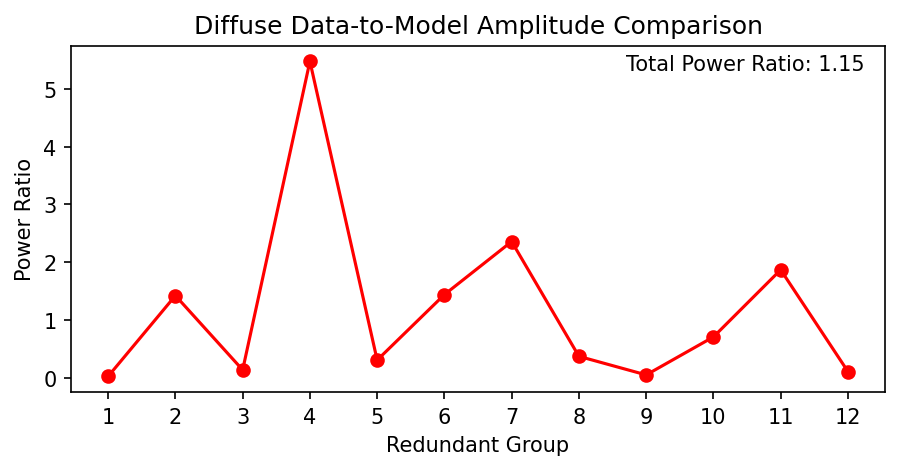

In [19]:
red_vis = diff_data[edges[:-1]//2]
model_vis = diff_mat[edges[:-1],0]
power_ratio = np.abs(red_vis)**2 / np.abs(model_vis)**2
total_power_ratio = np.mean(np.abs(red_vis)**2) / np.mean(np.abs(model_vis)**2)
fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=150)
ax.set_xlabel("Redundant Group")
ax.set_ylabel("Power Ratio")
ax.set_title("Diffuse Data-to-Model Amplitude Comparison")
ax.plot(np.arange(1, edges.size), power_ratio, color='r', marker='o')
ax.text(0.975, 0.975, f"Total Power Ratio: {total_power_ratio:.2f}", ha="right", va="top", transform=ax.transAxes)
ax.set_xticks(np.arange(1, edges.size));

**Figure 3 |** Ratio of the measured power to the expected power in each redundant group. If the diffuse matrix calculation was performed correctly, then this ratio should be randomly distributed about unity.

### Source Matrix

The source matrix encodes the interferometer's response to point sources and ultimately drives the quality of the phase calibration. Compared to the diffuse matrix, the source matrix is fairly straightforward to compute, since each column in the source matrix is just the response of the array to each calibration source. Because we alternate between real and imaginary components along the baseline axis, the source matrix elements are given by

$$
    \Sigma_{kj} = \begin{cases}
        {\rm Re}\Bigl( A\bigl(\hat{\mathbfit{r}}_j\bigr) s_j \exp\bigl(-i2\pi\nu\mathbfit{b}_k \cdot \hat{\mathbfit{r}}_j/c\bigr)\Bigr), \quad j\ {\rm is\ even} \\
        {\rm Im}\Bigl( A\bigl(\hat{\mathbfit{r}}_j\bigr) s_j \exp\bigl(-i2\pi\nu\mathbfit{b}_k \cdot \hat{\mathbfit{r}}_j/c\bigr)\Bigr), \quad j\ {\rm is\ odd} \\
    \end{cases},
$$

where $\hat{\mathbfit{r}}_j$ is a unit vector pointing to source $j$ with flux density $s_j$, $\mathbfit{b}_k$ is the baseline vector for the antenna pair $(a_{k_1}, a_{k_2})$, $\nu$ is the observing frequency, $c$ is the speed of light in vacuum, and $A(\hat{\mathbfit{r}})$ is the primary (power) beam. One of the key conditions for enabling CorrCal to run efficiently is that the number of sources used for calibration is much less than the number of baselines used to provide constraints from the measured data. Accordingly, only a handful of sources are used in typical applications of CorrCal. What this means in terms of constructing the source matrix is that we must first make a decision about which sources to use for calibration, then compute the source matrix elements with those select few sources. The brightest sources <i>as seen by the telescope</i> will provide the tightest phase calibration.

In [20]:
# Convert the source positions to the local frame.
source_positions = SkyCoord(
    Longitude(ra), Latitude(dec), frame="icrs"
).transform_to(local_frame)

# Only sources above the horizon contribute to the measured visibility.
above_horizon = source_positions.alt > 0

# This selects sources that are close to where the array is most sensitive.
near_zenith = source_positions.alt.deg > 80

# This chooses sources brighter than some (arbitrary) cutoff.
is_bright = fluxes.to(units.Jy).value > 100

# The calibration candidates are either near zenith or very bright and above the horizon.
# There are times when a very bright source can contribute appreciably even though it is
# very deep in the beam sidelobes, which is what the second term captures.
select = near_zenith | (is_bright & above_horizon)

In [21]:
# Extract the source AltAz coordinates and fluxes for the calibration candidates.
# pyuvdata defines azimuth as North of East; astropy defines it as East of North.
src_az = Longitude(np.pi/2*units.rad - source_positions.az)[select].to(units.rad).value
src_za = np.pi/2 - source_positions.alt.rad[select]
src_flux = fluxes[select].to(units.Jy).value

# Evaluate the antenna response in each source position.
beam_vals = beam.power_eval(
    az_array=src_az, za_array=src_za, freq_array=np.array([freq]),
)[0][0,0]
weighted_fluxes = beam_vals * src_flux

# Now pick the n_src brightest observed sources for calibration.
n_src = 1
sort = np.argsort(weighted_fluxes)[::-1]
src_az = src_az[sort][:n_src]
src_za = src_za[sort][:n_src]

# The factor of 0.5 is applied to match the matvis Stokes convention.
src_flux = 0.5 * weighted_fluxes[sort][:n_src]

In [22]:
# Compute the unit vectors pointing to the sources.
src_nhat = np.array(
    [np.sin(src_za)*np.cos(src_az), np.sin(src_za)*np.sin(src_az), np.cos(src_za)]
)

# Now compute the fringe terms for each source and baseline.
uvws = baselines / wavelength
src_fringe = np.exp(-2j * np.pi * uvws @ src_nhat)

# The source matrix is just the alternating real/imag parts of the "per source" visibilities.
src_vis = src_flux[None,:] * src_fringe
src_mat = np.zeros((edges[-1], n_src), dtype=float)
src_mat[::2] = src_vis.real
src_mat[1::2] = src_vis.imag

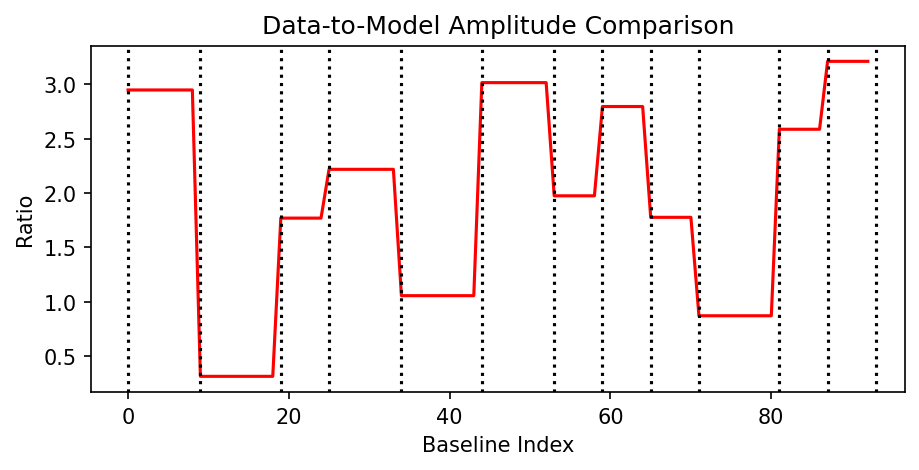

In [23]:
# Now do a quick sanity check.
src_data = np.array(
    [
        src_uvdata.get_data(ai,aj,'xx')[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=150)
ax.set_xlabel("Baseline Index")
ax.set_ylabel("Ratio")
ax.set_title("Data-to-Model Amplitude Comparison")
ax.plot(np.abs(src_data) / np.abs(src_vis.sum(axis=1)), color='r')
for idx in edges//2:
    ax.axvline(idx, color='k', ls=':');

**Figure 4 |** Ratio of the measured power from point sources to the modeled power from point sources (after allowing the sources to interfere). If most of the source power is dominated by the calibration sources, then this ratio should be close to unity.

## Run Calibration

With the diffuse matrix and source matrix in hand, we have almost all of the ingredients we need to run the calibration. In addition to the source and diffuse matrices, we need to compute an estimate of the noise, sort the data into redundant groups, and come up with an initial guess at the gains. Since this is a simulation-based tutorial, we will simulate the gains on the fly and choose an initial guess nearby the true values.

### Sorting into Redundant Groups

There are several ways to go about sorting the data into redundant groups, but at the very least each of these must produce an `edges` array that denotes where each redundant group starts and stops. The `edges` array should be configured so that `slice(edges[i], edges[i+1])` gives all of the data (or covariance elements) for redundant group `i`. The method used for generating the `edges` array must also produce the `ant_1_array` and `ant_2_array` objects, which keep track of which antennas are used to form the baselines used in calibration.  
  
Additionally, not all baselines need to be used for calibration&mdash;the base version of `CorrCal` assumes that there are no correlations between different redundant groups, and this assumption is particularly bad for the shortest baselines in a compact array, since the beam kernels for these groups may have substantial $uv$-overlap. In addition to this, the number of eigenmodes that may be used for calibration are limited by the size of the smallest group used for calibration, so approaches that try to capture some of the non-redundancy in the eigenspectrum should discard groups with fewer baselines than the number of eigenmodes that are kept (or zeropad those smaller groups, although the core CorrCal code does not provide tools for doing this). This example shows how to compute the `edges` array and sort the data using `pyuvdata`.  
  
Note that we already did this earlier using the convenience function in `corrcal`, but it is worthwhile to see one approach explicitly.

In [24]:
# Initialize things for making the groups.
reds, _, lens, conj = uvdata.get_redundancies(include_conjugates=True)
conj = set(conj)  # To make lookup faster
ant_1_array = []
ant_2_array = []
edges = [0,]
idx = 0  # To count where we are when building the arrays

# Loop over the redundant groups and build the relevant arrays.
for group, bl_length in zip(reds, lens):
    # Only keep baselines longer than min_bl_len and with a minimum redundancy of min_group_size.
    if (bl_length < min_bl_len) or (len(group) < min_group_size):
        continue
    
    for bl in group:
        # Convert the baseline number into an antenna pair
        ai, aj = uvdata.baseline_to_antnums(bl)
        if bl in conj:
            ai, aj = aj, ai
        ant_1_array.append(ai)
        ant_2_array.append(aj)
        idx += 1
    edges.append(idx)
    
ant_1_array = np.array(ant_1_array)
ant_2_array = np.array(ant_2_array)
edges = np.array(edges)

In [25]:
# There is also a convenience function for this in corrcal
ant_1_array, ant_2_array, edges = corrcal.gridding.make_groups_from_uvdata(
    uvdata, min_bl_len=min_bl_len, min_group_size=min_group_size
)

In [26]:
# Now we can use these arrays to retrieve the data.
data = np.array(
    [
        uvdata.get_data(ai, aj, "xx").flatten()[0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

### Noise Estimation

In an actual calibration scenario, the noise should be estimated directly from the data. This can be done through differencing nearest neighbors (with an arbitrary choice of weighting kernel, as long as it's sensible), or by employing the radiometer equation. Since we're not including any noise in this simulation, we'll just use the noise matrix as a normalization term to help with inversion stability.

In [27]:
autocorr = uvdata.get_data(0, 0, "xx")[0,0]
noise_amp = 1e-4 * autocorr.real  # This is radiometer with dnu dt = 1e8
noise = np.ones(edges[-1], dtype=float) * noise_amp**2

### Gain Simulation

Now that we have the data sorted into redundant groups and the last piece of the covariance matrix, we can simulate the gains and produce an initial guess at the gains. To keep things simple, but not trivial, we'll take the gain amplitudes to be distributed like $|g| \sim \mathcal{N}(1, 0.1^2)$, while the phases will be uniformly distributed on $[0,2\pi)$. The initial guess will have about 10% amplitude errors and 0.05 radian phase errors. These are arbitrarily chosen; feel free to experiment with how initial guess accuracy propagates to the calibration solutions and impacts the convergence time.

In [28]:
# Choose some gain parameters
gain_amp = 1
amp_jitter = 0.1  # 10% jitter in the true gain amplitudes
amp_error = 0.1  # 10% errors in the initial guesses for the gains
phs_error = 0.05  # average error on the gain phase, in radians

# Simulate the gains
n_ants = uvdata.Nants_data
gain_amplitudes = np.random.normal(
    size=n_ants, loc=gain_amp, scale=amp_jitter
)
gain_phases = np.random.uniform(0, 2*np.pi, n_ants)
true_gains = gain_amplitudes * np.exp(1j*gain_phases)

# Now take a perturbation on the true gains as the initial guess
init_amp = gain_amplitudes * np.random.normal(
    size=n_ants, loc=1, scale=amp_error
)
init_phs = gain_phases + np.random.normal(
    size=n_ants, loc=0, scale=phs_error
)
init_gains = init_amp * np.exp(1j*init_phs)

In [29]:
# Now apply the gains to the data.
uncal_data = data * true_gains[ant_1_array] * true_gains[ant_2_array].conj()

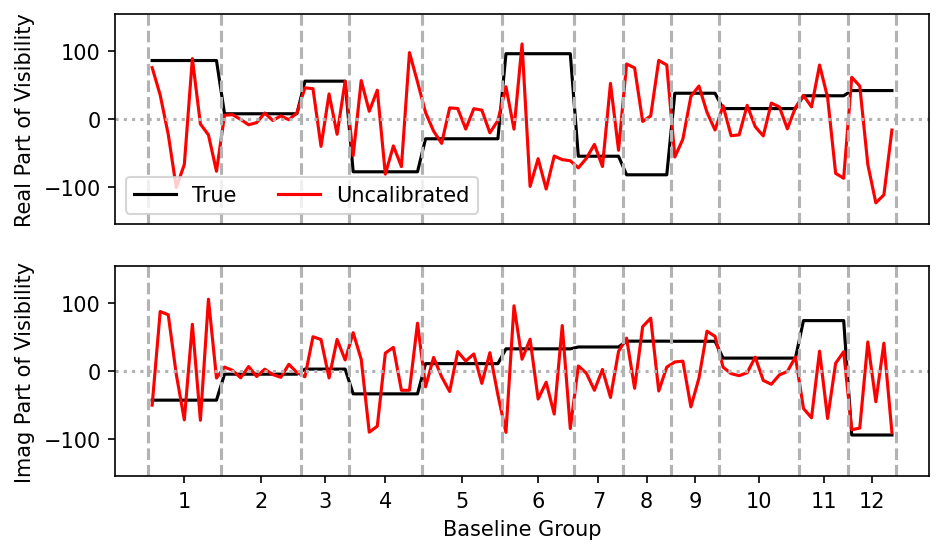

In [30]:
# Before running calibration, let's get a sense of why we need to calibrate.
fig, axes = plt.subplots(2, 1, figsize=(7,4), dpi=150)
axes[0].xaxis.set_visible(False)
axes[0].set_ylabel("Real Part of Visibility")
axes[1].set_ylabel("Imag Part of Visibility")

axes[0].plot(0.5 + np.arange(ant_1_array.size), data.real, color='k', label="True")
axes[0].plot(0.5 + np.arange(ant_1_array.size), uncal_data.real, color='r', label="Uncalibrated")
axes[1].plot(0.5 + np.arange(ant_1_array.size), data.imag, color='k')
axes[1].plot(0.5 + np.arange(ant_1_array.size), uncal_data.imag, color='r')
axes[0].legend(ncol=2)

vmax = 1.5 * np.abs(data).max()

for ax in axes:
    ax.set_ylim(-vmax, vmax)
    ax.axhline(0, color="0.7", ls=":")
    for edge in edges//2:
        ax.axvline(edge, color="0.7", ls="--")

axes[1].set_xlabel("Baseline Group")
axes[1].set_xticks(0.5 * (edges[1:] + edges[:-1])/2)
axes[1].set_xticklabels(range(1,len(edges)));

**Figure 5 |** Comparison of the uncalibrated visibilities against the true visibilities. The gains cause the visibilities to deviate substantially from their expected values, which motivates the need for calibration.

### Running the Minimizer

`CorrCal` performs calibration by minimizing the negative log-likelihood  
  
$$
    -\log\mathcal{L} = \log{\rm det} {\bf C} + \mathbfit{d}^T {\bf C}^{-1} \mathbfit{d},
$$
  
where $\mathbfit{d}$ is the visibility data being calibrated, split into alternating real and imaginary parts. Routines for computing the likelihood and its gradient are provided in the `optimize` module. This section shows how to initialize a sparse covariance object and run calibration using `scipy` for optimization.

In [31]:
# Create the sparse covariance object.
cov = corrcal.sparse.SparseCov(
    noise=noise,
    diff_mat=diff_mat,
    src_mat=src_mat,
    edges=edges,
    n_eig=2*n_eig,
    isinv=False,
)

In [32]:
# Set up the additional arguments the objective function needs.
gain_scale = 1  # Scaling factor to help with convergence time.
phs_norm = 0.1  # How close to zero phase the calibration solutions should be.

# Split the data into alternating real/imaginary components
split_data = np.zeros(edges[-1], dtype=float)
split_data[::2] = uncal_data.real
split_data[1::2] = uncal_data.imag
opt_args = (
    cov, split_data, ant_1_array, ant_2_array, gain_scale, phs_norm
)

# Split up the gains into the real/imaginary parts for calibration.
split_gains = np.zeros(2*n_ants, dtype=float)
split_gains[::2] = init_gains.real
split_gains[1::2] = init_gains.imag

# Now run the optimization.
result = minimize(
    corrcal.optimize.nll,
    gain_scale*split_gains,
    args=opt_args,
    method="CG",  # Use the conjugate-gradient solver
    jac=corrcal.optimize.grad_nll,
)

### Inspect Calibration Results

In [33]:
# Per-antenna gain phases are only meaningful relative to some reference antenna.
gain_soln = corrcal.utils.rephase_to_ant(
    result.x[::2] + 1j*result.x[1::2], 0
)
true_gains = corrcal.utils.rephase_to_ant(true_gains, 0)

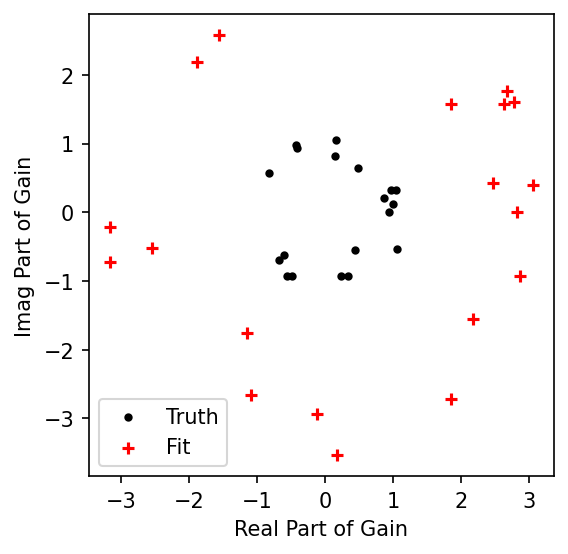

In [34]:
# First, let's look at the gain solutions in the complex plane.
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_xlabel("Real Part of Gain")
ax.set_ylabel("Imag Part of Gain")

ax.scatter(true_gains.real, true_gains.imag, color="k", marker=".", label="Truth")
ax.scatter(gain_soln.real, gain_soln.imag, color="r", marker="+", label="Fit")
ax.legend();

**Figure 6 |** Gains plotted in the complex plane. The black dots mark the true gains, while the red crosses mark the fit gains. The gains typically feature an amplitude offset and a spatial gradient in the phase due to the use of an incomplete source catalog and statistical description of the diffuse sky.

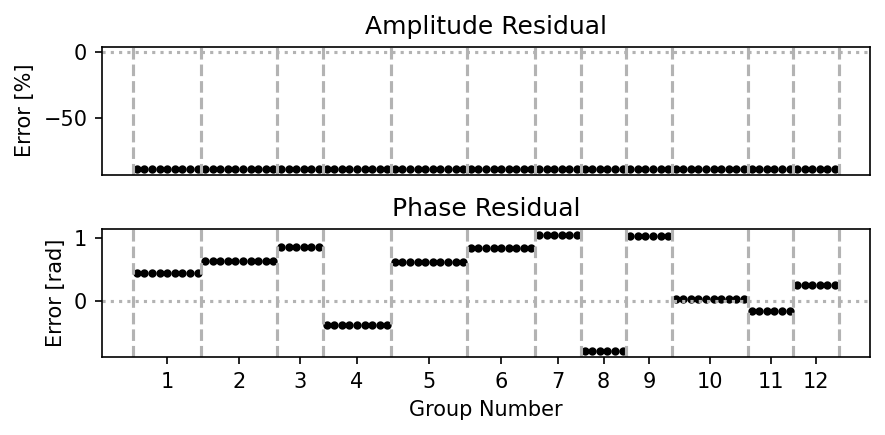

In [35]:
# Now let's look at the calibrated data.
fig, axes = plt.subplots(2, 1, figsize=(6,3), dpi=150)
axes[1].set_xlabel("Group Number")
axes[0].set_title("Amplitude Residual")
axes[1].set_title("Phase Residual")
axes[0].set_ylabel("Error [%]")
axes[1].set_ylabel("Error [rad]")

true_data = np.array(
    [
        uvdata.get_data(ai, aj, "xx")[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)
true_gain_mat = true_gains[ant_1_array] * true_gains[ant_2_array].conj()
fit_gain_mat = gain_soln[ant_1_array] * gain_soln[ant_2_array].conj()
cal_data = true_data * true_gain_mat / fit_gain_mat
amp_resid = 100 * (
    np.abs(cal_data) - np.abs(true_data)
) / np.abs(true_data)
phs_resid = np.angle(true_data * cal_data.conj())

axes[0].plot(
    0.5 + np.arange(ant_1_array.size), amp_resid, color="k", marker=".", lw=0
)
axes[1].plot(
    0.5 + np.arange(ant_1_array.size), phs_resid, color="k", marker=".", lw=0
)

for ax in axes:
    ax.axhline(0, color="0.7", ls=":")
    for edge in edges//2:
        ax.axvline(edge, color="0.7", ls="--")

axes[1].set_xticks(0.5 * (edges[1:] + edges[:-1])/2)
axes[1].set_xticklabels(range(1,len(edges)))        
axes[0].xaxis.set_visible(False)
fig.tight_layout();

**Figure 7 |** Amplitude and phase residuals of the calibrated data. The top panel shows the fractional error in the calibrated visibility amplitude, while the bottom panel shows the phase error in the calibrated visibilities. Note that the amplitude is biased, but fluctuations about this offset are small. Also note that while phase errors may deviate a bit from zero, there is very little scatter within each redundant group&mdash;this indicates that calibration errors should only lead to small levels of decoherence when redundantly averaging data. Remember that this calibration only used a single (albeit bright) source for phase calibration. As a closing note, it is worthwhile to rerun the calibration for different gain realizations; sometimes the solver starts off in an unfortunate part of parameter space that it has difficulty escaping, while other times it can lock in on a rather good solution.

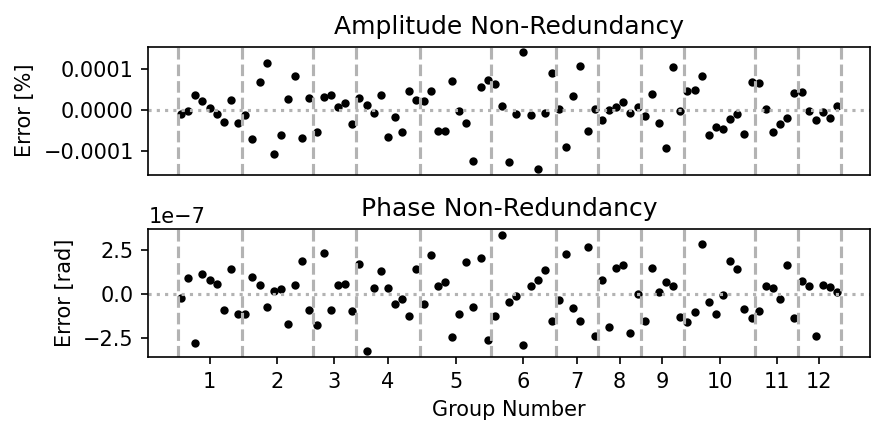

In [36]:
# Now let's look at the deviations within each redundant group.
fig, axes = plt.subplots(2, 1, figsize=(6,3), dpi=150)
axes[1].set_xlabel("Group Number")
axes[0].set_title("Amplitude Non-Redundancy")
axes[1].set_title("Phase Non-Redundancy")
axes[0].set_ylabel("Error [%]")
axes[1].set_ylabel("Error [rad]")

true_data = np.array(
    [
        uvdata.get_data(ai, aj, "xx")[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)
true_gain_mat = true_gains[ant_1_array] * true_gains[ant_2_array].conj()
fit_gain_mat = gain_soln[ant_1_array] * gain_soln[ant_2_array].conj()
cal_data = true_data * true_gain_mat / fit_gain_mat
amp_resid = np.zeros(cal_data.size)
phs_resid = np.zeros_like(amp_resid)
for start, stop in zip(edges//2, edges[1:]//2):
    amp_resid[start:stop] = 100 * (
        np.abs(cal_data[start:stop]) - np.abs(cal_data[start:stop]).mean()
    ) / np.abs(cal_data[start:stop]).mean()
    phs_resid[start:stop] = np.angle(
        cal_data[start:stop] * cal_data[start:stop].mean().conj()
    )

axes[0].plot(
    0.5 + np.arange(ant_1_array.size), amp_resid, color="k", marker=".", lw=0
)
axes[1].plot(
    0.5 + np.arange(ant_1_array.size), phs_resid, color="k", marker=".", lw=0
)

for ax in axes:
    ax.axhline(0, color="0.7", ls=":")
    for edge in edges//2:
        ax.axvline(edge, color="0.7", ls="--")

axes[1].set_xticks(0.5 * (edges[1:] + edges[:-1])/2)
axes[1].set_xticklabels(range(1,len(edges)))        
axes[0].xaxis.set_visible(False)
fig.tight_layout();

**Figure 8 |** Deviations from perfect redundancy in the visibility amplitude (top panel) and visibility phase (bottom panel). For this particular scenario, non-redundancies tend to show up at about one part in $10^5$ to $10^7$ in the visibility amplitude and phase. Because the residuals are so small, to leading order the fractional amplitude non-redundancy tracks the fractional non-redundancy in the real part, while the phase non-redundancy tracks the fractional non-redundancy in the imaginary part.

In [37]:
# Let's remove the overall amplitude offset and the phase slope to get a closer look.
amp_scale = np.abs(true_gains).mean() / np.abs(gain_soln).mean()

# Since we know the answer, we can do a linear least-squares fit for the phase slope.
phs_resid = np.angle(true_data * cal_data.conj())
M = np.linalg.inv(baselines[:,:2].T @ baselines[:,:2]) @ baselines[:,:2].T
phs_grad = M @ phs_resid
phs_offsets = enu_antpos[:,:2] @ phs_grad
updated_gains = amp_scale * gain_soln * np.exp(1j*phs_offsets)
updated_gains *= np.exp(-1j*np.angle(updated_gains[0]))

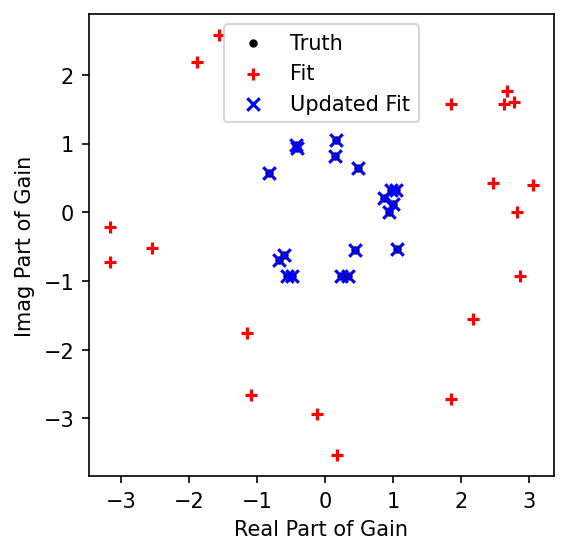

In [38]:
# First, let's look at the gain solutions in the complex plane.
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_xlabel("Real Part of Gain")
ax.set_ylabel("Imag Part of Gain")

ax.scatter(true_gains.real, true_gains.imag, color="k", marker=".", label="Truth")
ax.scatter(gain_soln.real, gain_soln.imag, color="r", marker="+", label="Fit")
ax.scatter(updated_gains.real, updated_gains.imag, color="b", marker="x", label="Updated Fit")
ax.legend();

**Figure 9 |** Comparison of the input gains (black circles), the gains fit by the solver (red plus marks), and the fit gains after correcting for an extant phase gradient and amplitude offset (blue crosses). In the absence of additional systematics in the data, the gain solutions are extremely accurate after removing a phase slope and overall amplitude scaling.

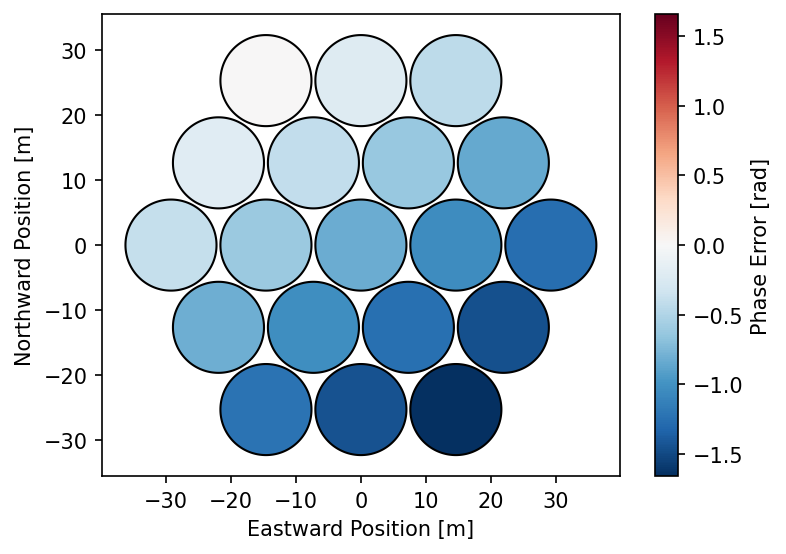

In [39]:
# Let's visualize the phase gradient to help build some context.
per_ant_phs_resid = np.angle(gain_soln * true_gains.conj())

# Figure out a nice normalization scheme for the plot.
vmax = np.abs(per_ant_phs_resid).max()
vmin = -vmax
norm = plt.cm.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.RdBu_r
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Actually make the figure now.
rim = 0.5 * diameter * np.exp(1j * np.linspace(0, 2*np.pi, 360))
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=150)
for ant, (e,n,u) in array_layout.items():
    ax.fill(e+rim.real, n+rim.imag, facecolor=cmap(norm(per_ant_phs_resid[ant])), edgecolor='k')

ax.set_aspect("equal")
ax.set_xlabel("Eastward Position [m]")
ax.set_ylabel("Northward Position [m]")
cbar = fig.colorbar(smap, ax=ax)
cbar.set_label("Phase Error [rad]")

**Figure 10 |** Visualization of the phase gradient in the gain solution. The presence of a gradient is due to an incomplete source catalog used for calibration and is investigated somewhat further in Section 5.4 of Pascua, Sievers, & Liu (2026). You should try experimenting with different choices of source matrix to see how the phase gradient interacts with modeling choices.

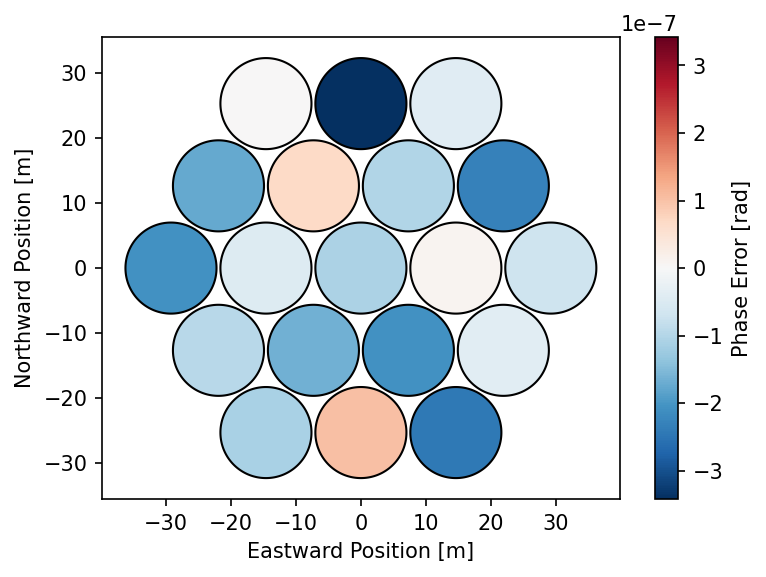

In [40]:
# Now let's see how it looks after the phase slope correction.
per_ant_phs_resid = np.angle(updated_gains * true_gains.conj())

# Figure out a nice normalization scheme for the plot.
vmax = np.abs(per_ant_phs_resid).max()
vmin = -vmax
norm = plt.cm.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.RdBu_r
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Actually make the figure now.
rim = 0.5 * diameter * np.exp(1j * np.linspace(0, 2*np.pi, 360))
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=150)
for ant, (e,n,u) in array_layout.items():
    ax.fill(e+rim.real, n+rim.imag, facecolor=cmap(norm(per_ant_phs_resid[ant])), edgecolor='k')

ax.set_aspect("equal")
ax.set_xlabel("Eastward Position [m]")
ax.set_ylabel("Northward Position [m]")
cbar = fig.colorbar(smap, ax=ax)
cbar.set_label("Phase Error [rad]")

**Figure 11 |** Phase errors for each antenna after the removal of the phase gradient. The scatter here is comparable to the phase non-redundancy in the calibrated visibilities, which is expected for gain solutions that are unbiased up to a spatial phase gradient term.